
# SOLAQUA — Sonar Visualizer (Updated)

This notebook auto-detects **Sonoptix** and **Ping360** exports produced by your updated data utils.

What it handles:
- **SonoptixECHO** stored as a 2D `image` (JSON) with optional `rows/cols` → shows frames and can convert to a 2D point cloud slice.
- **Ping360** stored as `bearing_deg` + `bins` (JSON list) → shows **polar** and **Cartesian** waterfalls.

### How to use
1. Run the cell below to **scan** for candidate files under `exports/by_bag/`.
2. Set `DATA_FILE` to one of the printed paths (CSV or Parquet).
3. Set a **frame index** (e.g., `FRAME_INDEX = 0`) for Sonoptix.
4. Run the plotting cells.


In [1]:

from pathlib import Path
import json, numpy as np, pandas as pd

SEARCH_ROOT = Path("exports/by_bag")
print("Scanning:", SEARCH_ROOT.resolve())

candidates = []
if SEARCH_ROOT.exists():
    for p in SEARCH_ROOT.rglob("*"):
        if p.suffix.lower() in {".csv", ".parquet"}:
            if any(tok in p.name.lower() for tok in ["sonoptix", "echo", "ping360", "ping"]):
                candidates.append(p)

for i, p in enumerate(sorted(candidates)):
    print(f"[{i}] {p}")
if not candidates:
    print("(no matching files found yet — export first)")

def load_df(path: Path | str) -> pd.DataFrame:
    """Load a dataframe from CSV or Parquet by file extension."""
    path = Path(path)
    return pd.read_parquet(path) if path.suffix.lower() == ".parquet" else pd.read_csv(path)

def load_df_auto(path: Path | str) -> pd.DataFrame:
    """Alias of load_df; kept for backwards compatibility."""
    return load_df(path)

Scanning: /Users/eirikvarnes/code/SOLAQUA/exports/by_bag
[0] exports/by_bag/sensor_ping360__2024-08-20_13-39-34_data.csv
[1] exports/by_bag/sensor_ping360__2024-08-20_13-40-35_data.csv
[2] exports/by_bag/sensor_ping360_config__2024-08-20_13-39-34_data.csv
[3] exports/by_bag/sensor_ping360_config__2024-08-20_13-40-35_data.csv
[4] exports/by_bag/sensor_ping360_config__2024-08-22_14-06-43_data.csv
[5] exports/by_bag/sensor_ping360_config__2024-08-22_14-29-05_data.csv
[6] exports/by_bag/sensor_ping360_config__2024-08-22_14-47-39_data.csv
[7] exports/by_bag/sensor_sonoptix_echo_image__2024-08-20_13-39-34_video.csv
[8] exports/by_bag/sensor_sonoptix_echo_image__2024-08-20_13-40-35_video.csv
[9] exports/by_bag/sensor_sonoptix_echo_image__2024-08-22_14-06-43_video.csv
[10] exports/by_bag/sensor_sonoptix_echo_image__2024-08-22_14-29-05_video.csv
[11] exports/by_bag/sensor_sonoptix_echo_image__2024-08-22_14-47-39_video.csv


## Pick a file and load it

In [2]:
# ========================== SONAR VIEW SETTINGS ==========================
# File/selection
DATA_FILE = "exports/by_bag/sensor_sonoptix_echo_image__2024-08-20_13-39-34_video.csv"
FRAME_INDEX = 530                 # which ping/frame to visualize

# Geometry / calibration (match your sonar setup)
FOV_DEG       = 120.0             # total horizontal field of view of the multibeam (deg)
RANGE_MIN_M   = 0.0               # near range in meters (typical: 0.0–1.0)
RANGE_MAX_M   = 30.0              # far range in meters (use the sonar's configured max range)
DISPLAY_RANGE_MAX_M = 10.0        # only display up to this range (UI zoom); does NOT change enhancement math
                                  # -> set this to the sonar's *actual* range if you know it (e.g., 10 m)

# Orientation (fix mirrored/rotated pictures)
SWAP_HW     = False               # False: rows=range bins, cols=beams (expected). True: transpose array.
FLIP_BEAMS  = False               # True to mirror left↔right (beam/angle axis)
FLIP_RANGE  = False               # True to mirror near↔far   (range axis)

# Enhancement (display-only; does NOT change the raw data)
# Use these to compensate for propagation loss and compress dynamic range.
ENH_SCALE = "db"                  # "db" -> apply 20*log10(amplitude); "linear" -> skip log
# Time-Variable Gain (TVG): compensates spherical spreading loss
# - "amplitude" ≈ +20*log10(r) (amplitude ∝ 1/r)
# - "power"     ≈ +40*log10(r) (power ∝ 1/r^2)
# - "none"      -> no range compensation
ENH_TVG   = "amplitude"           # "none" | "amplitude" | "power"
# Absorption (two-way path), rough order-of-magnitude:
#   ~0.001–0.005 dB/m (freshwater, 200–400 kHz)
#   ~0.005–0.02  dB/m (seawater, 400–900 kHz)
# Set to 0.0 if unknown; increase slightly if far ranges look too dim after TVG.
ENH_ALPHA_DB_PER_M = 0.0          # dB per meter, applied as +2*alpha*r
# Log floor to avoid -inf for zeros; raises the display "noise floor"
ENH_EPS_LOG = 1e-5                # amplitude floor before log10; larger -> fewer super-black zeros
# TVG guard to avoid log(0) at r≈0
ENH_R0 = 1e-6                     # meters
# Robust percentile clip (against outliers). Compute percentiles on selected pixels (see ZERO_AWARE).
ENH_P_LOW  = 1.0                  # lower percentile (e.g., 1.0–5.0)
ENH_P_HIGH = 99.5                 # upper percentile (e.g., 95–99.9)
# Gamma: <1 lifts midtones; >1 compresses highlights
ENH_GAMMA = 0.9
# Zero-aware scaling: ignore zeros when computing percentiles (recommended when many bins are 0)
ENH_ZERO_AWARE = True

# Colormaps / figure
CMAP_RAW = "viridis"              # for raw panel
CMAP_ENH = "viridis"              # for enhanced panel
FIGSIZE  = (12, 5.6)              # (width, height) inches
# ========================================================================


Loaded 699 rows with columns: ['t', 'bag', 'bag_file', 'topic', 'dim_labels', 'dim_sizes', 'dim_strides', 'rows', 'cols', 'image', 't0', 't_rel']
Prepared frame #530: shape=1024x256


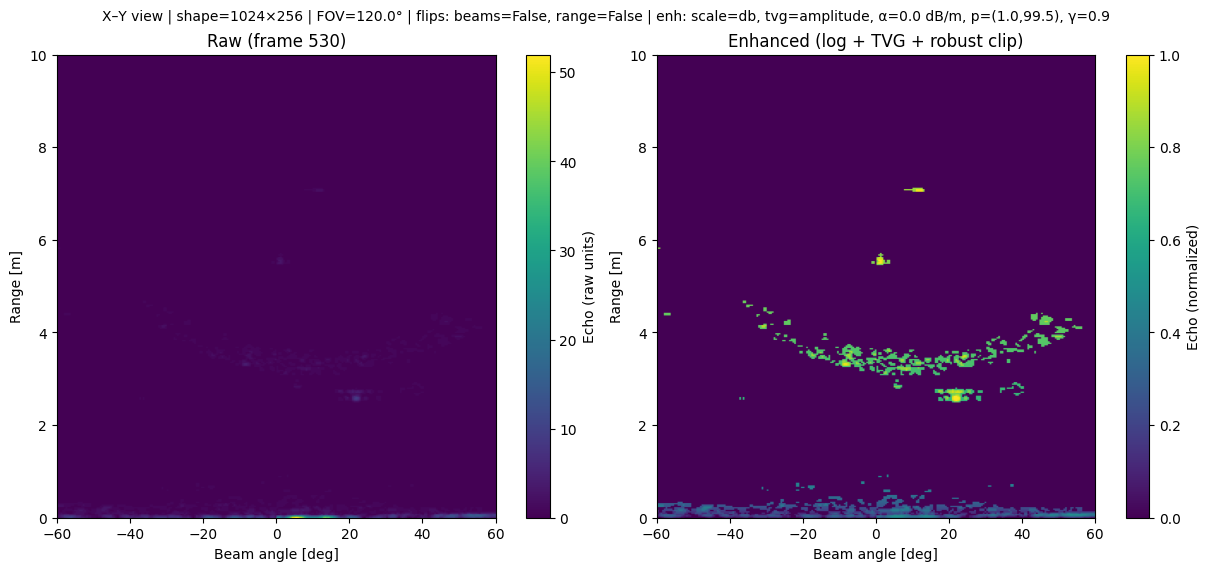

In [5]:
# === Processing & Display (run after the settings cell) ===
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- helpers ----------
def load_df(path: str | Path) -> pd.DataFrame:
    path = Path(path)
    return pd.read_parquet(path) if path.suffix.lower()==".parquet" else pd.read_csv(path)

def parse_json_cell(v):
    if isinstance(v, str):
        try: return json.loads(v)
        except Exception: return None
    return v

def infer_hw(labels, sizes, data_len):
    labels = [str(l or "").lower() for l in (labels or [])]
    sizes  = [int(s) for s in (sizes or [])]
    # Prefer explicit "height/rows/beams" × "width/cols/bins/range/samples"
    try:
        h_idx = max(i for i,l in enumerate(labels) if any(k in l for k in ("height","rows","beams")))
        w_idx = max(i for i,l in enumerate(labels) if any(k in l for k in ("width","cols","bins","range","samples")))
        H, W = sizes[h_idx], sizes[w_idx]
        if H>0 and W>0 and H*W==data_len: return H, W
    except Exception:
        pass
    # Fallback: any valid pair
    for i in range(len(sizes)):
        for j in range(i+1, len(sizes)):
            H, W = sizes[i], sizes[j]
            if H>0 and W>0 and H*W==data_len:
                return H, W
    return None, None

def get_sonoptix_frame(df: pd.DataFrame, idx: int) -> np.ndarray | None:
    if "image" in df.columns:
        img = parse_json_cell(df.loc[idx, "image"])
        if isinstance(img, list) and img and isinstance(img[0], list):
            return np.asarray(img, dtype=float)
    if "data" in df.columns:
        data   = parse_json_cell(df.loc[idx, "data"])
        labels = parse_json_cell(df.loc[idx, "dim_labels"]) if "dim_labels" in df.columns else None
        sizes  = parse_json_cell(df.loc[idx, "dim_sizes"])  if "dim_sizes"  in df.columns else None
        if isinstance(data, list):
            if isinstance(sizes, list):
                H, W = infer_hw(labels, sizes, len(data))
                if H and W: return np.asarray(data, dtype=float).reshape(H, W)
            H = int(df.loc[idx, "rows"]) if "rows" in df.columns and pd.notna(df.loc[idx, "rows"]) else None
            W = int(df.loc[idx, "cols"]) if "cols" in df.columns and pd.notna(df.loc[idx, "cols"]) else None
            if H and W and H*W==len(data):
                return np.asarray(data, dtype=float).reshape(H, W)
    return None

def enhance_intensity(
    M: np.ndarray,
    range_min: float, range_max: float,
    *,
    scale: str = ENH_SCALE,
    tvg: str = ENH_TVG,
    alpha_db_per_m: float = ENH_ALPHA_DB_PER_M,
    r0: float = ENH_R0,
    p_low: float = ENH_P_LOW,
    p_high: float = ENH_P_HIGH,
    gamma: float = ENH_GAMMA,
    zero_aware: bool = ENH_ZERO_AWARE,
    eps_log: float = ENH_EPS_LOG,
) -> np.ndarray:
    """Display enhancement: log (optional) + TVG + absorption + robust clip + gamma."""
    M = np.asarray(M, dtype=float)
    # 1) log (display compression)
    X = 20.0*np.log10(np.maximum(M, eps_log)) if scale == "db" else M.copy()
    # 2) TVG / absorption (use physical range from row index)
    n_rows = M.shape[0]
    r_edges = np.linspace(range_min, range_max, n_rows+1)
    r_cent  = 0.5*(r_edges[:-1] + r_edges[1:])
    R = np.broadcast_to(r_cent[:, None], M.shape)
    if tvg == "amplitude":
        X = X + 20.0*np.log10(np.maximum(R, r0))
    elif tvg == "power":
        X = X + 40.0*np.log10(np.maximum(R, r0))
    if alpha_db_per_m > 0:
        X = X + 2.0*alpha_db_per_m*R
    # 3) robust percentile range
    mask = np.isfinite(X)
    if zero_aware:
        mask &= (M > 0)
    vals = X[mask]
    if vals.size == 0:
        vmin, vmax = 0.0, 1.0
    else:
        vmin = np.percentile(vals, p_low)
        vmax = np.percentile(vals, p_high)
        if not np.isfinite(vmin): vmin = 0.0
        if not np.isfinite(vmax) or vmax <= vmin: vmax = vmin + 1e-6
    Y = np.clip((X - vmin) / (vmax - vmin), 0, 1)
    if gamma != 1.0:
        Y = np.power(Y, 1.0/gamma)
    return Y

# ---------- load & extract ----------
df = load_df(DATA_FILE)
print(f"Loaded {len(df)} rows with columns:", list(df.columns))

M0 = get_sonoptix_frame(df, FRAME_INDEX)
if M0 is None:
    raise RuntimeError("Could not construct a Sonoptix frame from this file.")

# Orientation
M = M0.T if SWAP_HW else M0.copy()
if FLIP_RANGE: M = M[::-1, :]
if FLIP_BEAMS: M = M[:, ::-1]

H, W = M.shape
print(f"Prepared frame #{FRAME_INDEX}: shape={H}x{W}")

# Axis extents for X–Y view
theta_min_deg = -0.5 * FOV_DEG
theta_max_deg =  0.5 * FOV_DEG
if SWAP_HW:
    # rows=beams, cols=range  (uncommon, only if you opt-in)
    extent_xy = (RANGE_MIN_M, RANGE_MAX_M, theta_min_deg, theta_max_deg)
    xlab, ylab = "Range [m]", "Beam angle [deg]"
else:
    # rows=range, cols=beams  (default)
    extent_xy = (theta_min_deg, theta_max_deg, RANGE_MIN_M, RANGE_MAX_M)
    xlab, ylab = "Beam angle [deg]", "Range [m]"

# Build raw & enhanced
M_raw = M
vmin_raw, vmax_raw = float(np.nanmin(M_raw)), float(np.nanmax(M_raw))
M_enh = enhance_intensity(M_raw, RANGE_MIN_M, RANGE_MAX_M)

# ---------- plot ----------
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, constrained_layout=True)

# Raw
im0 = axes[0].imshow(M_raw, origin="lower", aspect="auto", extent=extent_xy,
                     vmin=vmin_raw, vmax=vmax_raw, cmap=CMAP_RAW)
axes[0].set_title(f"Raw (frame {FRAME_INDEX})")
axes[0].set_xlabel(xlab)
axes[0].set_ylabel(ylab)
# Display zoom in range (Y axis if not swapped)
if SWAP_HW:
    axes[0].set_xlim(RANGE_MIN_M, DISPLAY_RANGE_MAX_M)
else:
    axes[0].set_ylim(RANGE_MIN_M, DISPLAY_RANGE_MAX_M)
fig.colorbar(im0, ax=axes[0], label="Echo (raw units)")

# Enhanced
im1 = axes[1].imshow(M_enh, origin="lower", aspect="auto", extent=extent_xy,
                     vmin=0, vmax=1, cmap=CMAP_ENH)
axes[1].set_title("Enhanced (log + TVG + robust clip)")
axes[1].set_xlabel(xlab)
axes[1].set_ylabel(ylab)
if SWAP_HW:
    axes[1].set_xlim(RANGE_MIN_M, DISPLAY_RANGE_MAX_M)
else:
    axes[1].set_ylim(RANGE_MIN_M, DISPLAY_RANGE_MAX_M)
fig.colorbar(im1, ax=axes[1], label="Echo (normalized)")

fig.suptitle(
    f"X–Y view | shape={H}×{W} | FOV={FOV_DEG}° | flips: beams={FLIP_BEAMS}, range={FLIP_RANGE} | "
    f"enh: scale={ENH_SCALE}, tvg={ENH_TVG}, α={ENH_ALPHA_DB_PER_M} dB/m, p=({ENH_P_LOW},{ENH_P_HIGH}), γ={ENH_GAMMA}",
    fontsize=10
)
plt.show()


/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_17787/3558773817.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(CMAP).copy()


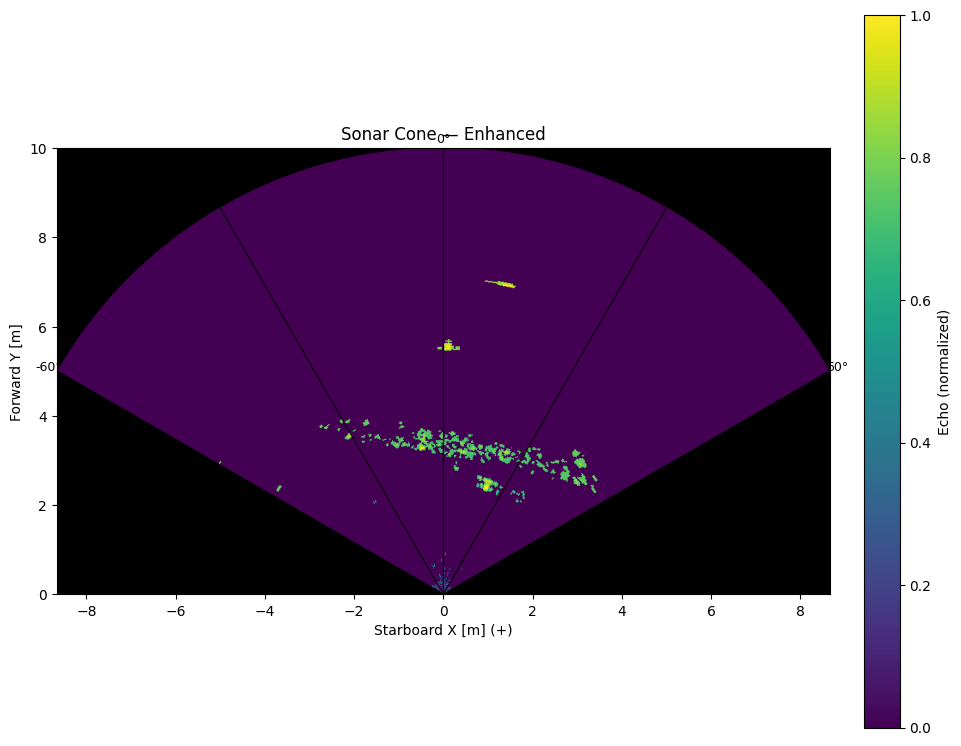

In [11]:
# === Rasterized Cone View (Cartesian resampling, axes flipped, spokes only) ===
import numpy as np
import matplotlib.pyplot as plt

# ----- options -----
USE_ENHANCED   = True        # True -> M_enh (0..1), False -> M_raw (raw units)
ROTATE_DEG     = 0.0         # rotate the fan; 0° means 0° beam points forward (+Y)
N_SPOKES       = 5           # number of angle spokes (incl. edges)
IMG_W, IMG_H   = 900, 700    # output raster resolution (px)
BG_COLOR       = "black"     # color outside the fan
CMAP           = CMAP_ENH if USE_ENHANCED else CMAP_RAW

# ----- guards -----
needed = ["M_raw","M_enh","H","W","FOV_DEG","RANGE_MIN_M","RANGE_MAX_M","vmin_raw","vmax_raw"]
for name in needed:
    if name not in globals():
        raise RuntimeError(f"Missing '{name}'. Run your X–Y cell first.")

# ----- choose data & scale -----
Z    = M_enh if USE_ENHANCED else M_raw         # shape (H, W): rows=range bins, cols=beams
vmin = 0.0 if USE_ENHANCED else float(vmin_raw)
vmax = 1.0 if USE_ENHANCED else float(vmax_raw)

# Fan bounds use DISPLAY_RANGE_MAX_M
half = np.deg2rad(0.5 * FOV_DEG)
x_max =  np.sin(half) * DISPLAY_RANGE_MAX_M
x_min = -x_max
y_min = max(0.0, RANGE_MIN_M)
y_max = DISPLAY_RANGE_MAX_M 

# Regular Cartesian grid: horizontal = starboard X, vertical = forward Y
x = np.linspace(x_min, x_max, IMG_W)
y = np.linspace(y_min, y_max, IMG_H)
Xg, Yg = np.meshgrid(x, y)  # shapes (IMG_H, IMG_W)

# Convert grid points to polar (angle measured from +Y forward, starboard positive)
# theta = 0 along +Y; positive to starboard (+X)
theta = np.arctan2(Xg, Yg)                           # [-pi, pi]
theta -= np.deg2rad(ROTATE_DEG)                      # apply rotation
r = np.hypot(Xg, Yg)

# Valid points inside the fan (use y_max instead of RANGE_MAX_M)
mask = (
    (r >= RANGE_MIN_M) & (r <= y_max) &      # <= clipped
    (theta >= -half) & (theta <= +half)
)

# Map (r, theta) -> (row, col) indices (rowf still maps across full H;
# that’s fine because we’re just not sampling beyond 10 m)
rowf = (r - RANGE_MIN_M) / max(RANGE_MAX_M - RANGE_MIN_M, 1e-12) * (H - 1)
colf = (theta + half) / max(2*half, 1e-12) * (W - 1)

# nearest-neighbor sampling
rows = np.rint(np.clip(rowf, 0, H - 1)).astype(int)
cols = np.rint(np.clip(colf, 0, W - 1)).astype(int)

# Build the raster (mask outside sector to NaN so cmap 'bad' color shows background)
img = np.full((IMG_H, IMG_W), np.nan, dtype=float)
flat = mask.ravel()
img.ravel()[flat] = Z[rows.ravel()[flat], cols.ravel()[flat]]

# Colormap with background color
cmap = plt.cm.get_cmap(CMAP).copy()
cmap.set_bad(BG_COLOR)

# Plot
fig, ax = plt.subplots(figsize=(9.5, 8.0), constrained_layout=True)
im = ax.imshow(img, origin="lower",
               extent=(x_min, x_max, y_min, y_max),
               aspect="equal", cmap=cmap, vmin=vmin, vmax=vmax)

ax.set_xlabel("Starboard X [m] (+)")
ax.set_ylabel("Forward Y [m]")
ax.set_title("Sonar Cone — " + ("Enhanced" if USE_ENHANCED else "Raw"))

# Spokes end at the clipped range
for a in np.linspace(-np.rad2deg(half), np.rad2deg(half), N_SPOKES):
    th = np.deg2rad(a + ROTATE_DEG)
    x_end = y_max * np.sin(th)   # starboard
    y_end = y_max * np.cos(th)   # forward
    ax.plot([0, x_end], [0, y_end], lw=0.9, alpha=0.85, color="k")
    ax.text(1.02*x_end, 1.02*y_end, f"{a:.0f}°", ha="center", va="center", fontsize=9)
    
# Colorbar tuned not to squeeze the plot
fig.colorbar(im, ax=ax, pad=0.02, shrink=0.9,
             label=("Echo (normalized)" if USE_ENHANCED else "Echo (raw units)"))
plt.show()

In [7]:
from pathlib import Path
import numpy as np
from rosbags.highlevel import AnyReader

BAG = Path("data/2024-08-20_13-39-34_video.bag")  # adjust if needed
TOPIC = "/sensor/sonoptix_echo/image"

with AnyReader([BAG]) as reader:
    conns = [c for c in reader.connections if c.topic == TOPIC]
    assert conns, f"Topic {TOPIC!r} not found"
    con = conns[0]

    for i, (_, t_ns, raw) in enumerate(reader.messages(connections=[con])):
        if i == 530:   # your frame index
            msg = reader.deserialize(raw, con.msgtype)
            arr = np.array(msg.array_data.data, dtype=np.float32)
            print("dtype:", arr.dtype, "min/max:", arr.min(), arr.max())
            fracmax = np.max(np.abs(np.modf(arr)[0]))
            print("max fractional part:", float(fracmax))
            uniq = np.unique(arr)
            print("unique_count:", len(uniq), "first 50 uniq:", uniq[:50])
            break


dtype: float32 min/max: 0.0 52.0
max fractional part: 0.0
unique_count: 42 first 50 uniq: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 30. 31. 33. 34. 37. 38. 40. 42.
 44. 47. 49. 50. 51. 52.]


In [8]:
from collections import Counter

counts = Counter()
nz_ratios = []
with AnyReader([BAG]) as reader:
    con = [c for c in reader.connections if c.topic == TOPIC][0]
    for _, _, raw in reader.messages(connections=[con]):
        msg  = reader.deserialize(raw, con.msgtype)
        arr2 = np.array(msg.array_data.data, dtype=np.float32)
        counts.update(np.unique(arr2).tolist())
        nz_ratios.append((arr2>0).mean())

print("unique values overall:", len(counts))
print("median %nonzero:", 100*np.median(nz_ratios))


unique values overall: 58
median %nonzero: 1.50909423828125


In [3]:
import numpy as np, pandas as pd, json
from pathlib import Path

DATA_FILE = Path(DATA_FILE)  # reuse your setting

df = pd.read_csv(DATA_FILE) if DATA_FILE.suffix.lower()==".csv" else pd.read_parquet(DATA_FILE)

# pull frame as a flat vector
img = np.array(json.loads(df.loc[FRAME_INDEX, "image"]), dtype=float)
vals = img.ravel()

# 1) how quantized?
is_int_like = np.allclose(vals, np.round(vals))
max_val = np.nanmax(vals); min_val = np.nanmin(vals)
uniq = np.unique(vals)
print("int-like:", bool(is_int_like), "min/max:", float(min_val), float(max_val), "unique_count:", len(uniq))

# 2) zero fraction and nonzero histogram
nz = vals[vals>0]
print("zero %:", 100.0*(vals.size - nz.size)/vals.size)
hist_bins = np.arange(min_val, max_val+2) if is_int_like and max_val-min_val<512 else 128
h, e = np.histogram(nz, bins=hist_bins)
print("nonzero histogram non-empty bins:", int(np.count_nonzero(h)))

# 3) check if everything is small integers like 0..63 (6-bit) or 0..255 (8-bit)
if is_int_like:
    print("likely bit depth ≤", int(np.ceil(np.log2(max_val+1))) if max_val>=1 else 1)

# 4) per-beam and per-range sparsity
H, W = img.shape
nz_per_col = (img>0).sum(axis=0) / H * 100.0
nz_per_row = (img>0).sum(axis=1) / W * 100.0
print("median %nonzero per beam:", float(np.median(nz_per_col)))
print("median %nonzero per range bin:", float(np.median(nz_per_row)))


int-like: True min/max: 0.0 52.0 unique_count: 42
zero %: 98.64692687988281
nonzero histogram non-empty bins: 41
likely bit depth ≤ 6
median %nonzero per beam: 1.171875
median %nonzero per range bin: 0.0


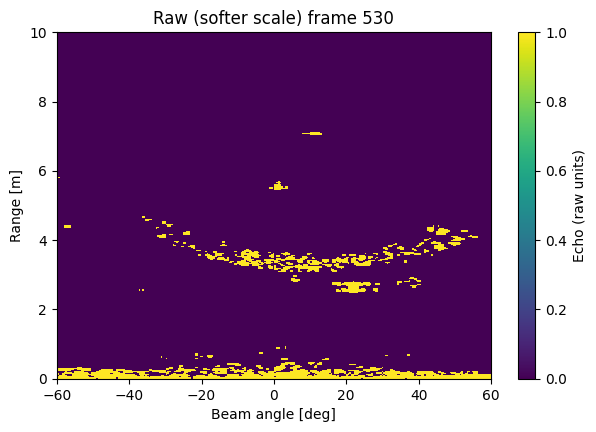

In [6]:
# Use your M_raw from earlier; if not available:
# from pathlib import Path; import json, numpy as np, pandas as pd
# df = pd.read_csv(DATA_FILE) if Path(DATA_FILE).suffix.lower()==".csv" else pd.read_parquet(DATA_FILE)
# M_raw = np.array(json.loads(df.loc[FRAME_INDEX,"image"]), dtype=float)

import matplotlib.pyplot as plt
import numpy as np

# 1) avoid per-frame hard clipping; use a mild percentile window INCLUDING zeros
p_low, p_high = 0.5, 99.0
vals = M_raw.ravel()
vmin = np.nanpercentile(vals, p_low)
vmax = np.nanpercentile(vals, p_high)
if not np.isfinite(vmin): vmin = np.nanmin(vals)
if not np.isfinite(vmax) or vmax <= vmin: vmax = vmin + 1e-6

# 2) small local smoothing JUST for display (doesn't invent noise; reduces the “blocky” look)
# comment this out if you want absolutely raw pixels
def box_blur(img, k=3):
    from scipy.ndimage import uniform_filter
    return uniform_filter(img, size=k, mode="nearest")
M_soft = M_raw  # or box_blur(M_raw, k=3) if you have scipy

# 3) show
fig, ax = plt.subplots(figsize=(7,4.5))
im = ax.imshow(M_soft, origin="lower", aspect="auto",
               extent=( -0.5*FOV_DEG, 0.5*FOV_DEG, RANGE_MIN_M, RANGE_MAX_M),
               vmin=vmin, vmax=vmax, cmap=CMAP_RAW, interpolation="nearest")  # no antialias
ax.set_title(f"Raw (softer scale) frame {FRAME_INDEX}")
ax.set_xlabel("Beam angle [deg]"); ax.set_ylabel("Range [m]")
fig.colorbar(im, ax=ax, label="Echo (raw units)")
ax.set_ylim(RANGE_MIN_M, DISPLAY_RANGE_MAX_M)
plt.show()
